True
R_manual：
 [[ 0.81379768 -0.46984631  0.34202014]
 [ 0.54383814  0.82317294 -0.16317591]
 [-0.20487413  0.31879578  0.92541658]]
R_intrinsic：
 [[ 0.99993969 -0.00913823  0.00609231]
 [ 0.00915691  0.99995344 -0.00304611]
 [-0.00606419  0.00310172  0.9999768 ]]
R_external：
 [[ 0.99993969 -0.00913823  0.00609231]
 [ 0.00915691  0.99995344 -0.00304611]
 [-0.00606419  0.00310172  0.9999768 ]]
euler_intrinsic：
 [10. 20. 30.]
euler_external：
 [30. 20. 10.]


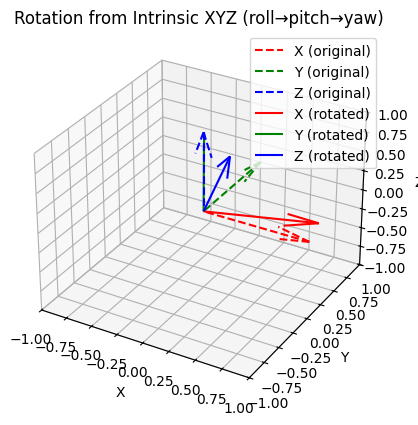

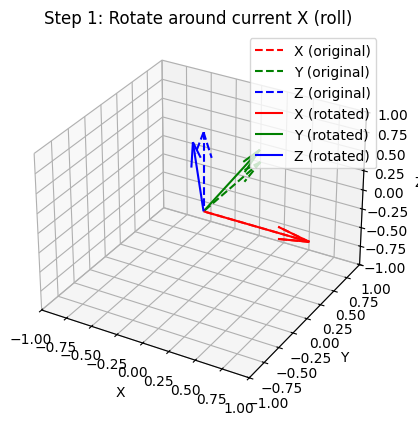

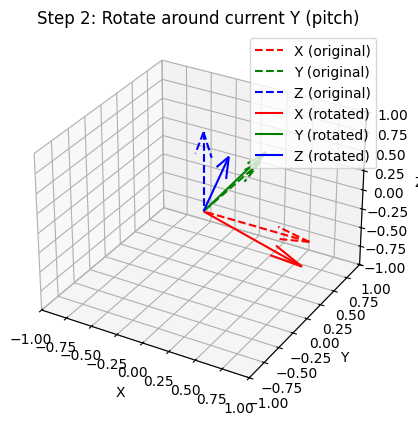

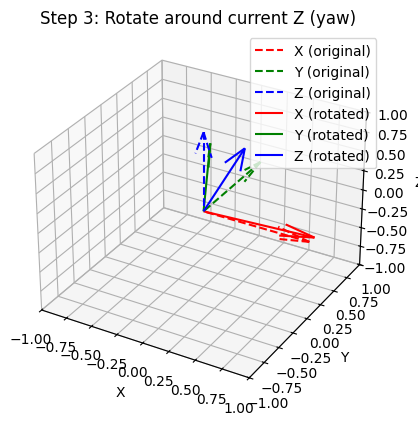

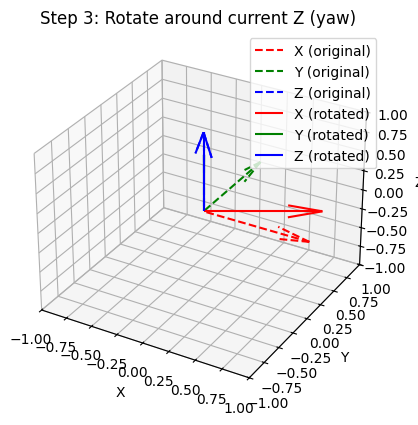

In [19]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_rotation(R_mat, title="Coordinate Frame Rotation", axis_length=1.0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    origin = np.zeros((3,))
    
    # 原始坐标系（单位向量）
    basis = np.eye(3)  # X, Y, Z 轴

    colors = ['r', 'g', 'b']
    labels = ['X', 'Y', 'Z']

    # 原始坐标系
    for i in range(3):
        ax.quiver(*origin, *basis[:, i], color=colors[i], linestyle='dashed', 
                  length=axis_length, normalize=True, label=f'{labels[i]} (original)')

    # 旋转后的坐标系
    for i in range(3):
        ax.quiver(*origin, *R_mat[:, i], color=colors[i], 
                  length=axis_length, normalize=True, label=f'{labels[i]} (rotated)')

    ax.set_xlim([-axis_length, axis_length])
    ax.set_ylim([-axis_length, axis_length])
    ax.set_zlim([-axis_length, axis_length])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()
    print()

# === Step 1: 定义欧拉角 ===
yaw, pitch, roll = 30, 20, 10  # 单位：度
yaw, pitch, roll = np.radians([yaw, pitch, roll])

# === Step 2: 手动构造每个轴的旋转矩阵 ===
def rot_z(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta),  np.cos(theta), 0],
        [0,              0,             1]
    ])

def rot_y(theta):
    return np.array([
        [np.cos(theta),  0, np.sin(theta)],
        [0,              1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
def rot_x(theta):
    return np.array([
        [1, 0,              0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta),  np.cos(theta)]
    ])

# === Step 3: 按照内旋顺序组合 ===
# 内旋：依次绕当前坐标系的 ZYX 轴 → 对应矩阵乘法 R = R_x * R_y * R_z（从右往左）
R_manual = rot_x(roll) @ rot_y(pitch) @ rot_z(yaw)

# === Step 4: 使用 scipy 验证内旋一致性 ===
R_intrinsic = R.from_euler('XYZ', [roll, pitch, yaw], degrees=True).as_matrix()
R_intrinsic_inv = np.linalg.inv(R_intrinsic)
R_external= R.from_euler('zyx', [yaw,pitch, roll], degrees=True).as_matrix()

R_external_inv= R.from_euler('xyz', [roll,pitch,yaw ], degrees=True).as_matrix()
A_inv_expected = R.from_euler('ZYX', [-yaw, -pitch, -roll], degrees=True).as_matrix()

rotation = R.from_matrix(R_manual)
euler_intrinsic = rotation.as_euler('XYZ', degrees=True)  
euler_external = rotation.as_euler('zyx', degrees=True)

# === Step 5: 比较 ===
print(np.allclose(R_intrinsic.T, A_inv_expected))
print("R_manual：\n", R_manual)
print("R_intrinsic：\n", R_intrinsic)
print("R_external：\n", R_external)
print("euler_intrinsic：\n", euler_intrinsic)
print("euler_external：\n", euler_external)

plot_rotation(R_manual, title="Rotation from Intrinsic XYZ (roll→pitch→yaw)")

Rx = rot_x(roll)
Ry = rot_y(pitch)
Rz = rot_z(yaw)

R1 = Rx                      # 第一步：绕初始X轴旋转 roll
R2 = Ry @ R1                # 第二步：绕“当前Y轴”旋转 pitch
R3 = Rz @ R2                # 第三步：绕“当前Z轴”旋转 yaw

plot_rotation(R1, title="Step 1: Rotate around current X (roll)")
plot_rotation(R2, "Step 2: Rotate around current Y (pitch)")
plot_rotation(R3, "Step 3: Rotate around current Z (yaw)")

plot_rotation(Rz, "Step 3: Rotate around current Z (yaw)")


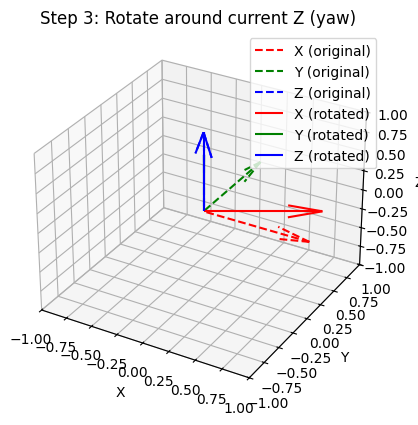

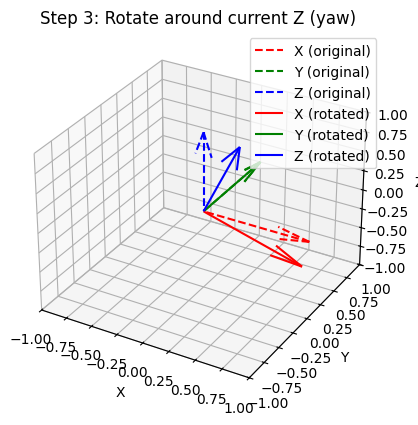

In [7]:
plot_rotation(Rz, "Step 3: Rotate around current Z (yaw)")
plot_rotation(Ry, "Step 3: Rotate around current Z (yaw)")


In [8]:
def plot_rotated_basis_by_point_rotation(R_mat, title="Rotation via Rotated Basis Vectors", axis_length=1.0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    origin = np.zeros(3)

    # 定义单位坐标轴的方向向量
    ex = np.array([1, 0, 0])
    ey = np.array([0, 1, 0])
    ez = np.array([0, 0, 1])

    # 应用旋转矩阵
    ex_rot = R_mat @ ex
    ey_rot = R_mat @ ey
    ez_rot = R_mat @ ez

    # 画原始坐标轴
    ax.quiver(*origin, *ex, color='r', linestyle='dashed', length=axis_length, normalize=True, label='X original')
    ax.quiver(*origin, *ey, color='g', linestyle='dashed', length=axis_length, normalize=True, label='Y original')
    ax.quiver(*origin, *ez, color='b', linestyle='dashed', length=axis_length, normalize=True, label='Z original')

    # 画旋转后的坐标轴
    ax.quiver(*origin, *ex_rot, color='r', length=axis_length, normalize=True, label='X rotated')
    ax.quiver(*origin, *ey_rot, color='g', length=axis_length, normalize=True, label='Y rotated')
    ax.quiver(*origin, *ez_rot, color='b', length=axis_length, normalize=True, label='Z rotated')

    # 设置图像属性
    ax.set_xlim([-axis_length, axis_length])
    ax.set_ylim([-axis_length, axis_length])
    ax.set_zlim([-axis_length, axis_length])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.show()

    # 打印旋转后的坐标轴向量
    print("Rotated X axis:", ex_rot)
    print("Rotated Y axis:", ey_rot)
    print("Rotated Z axis:", ez_rot)

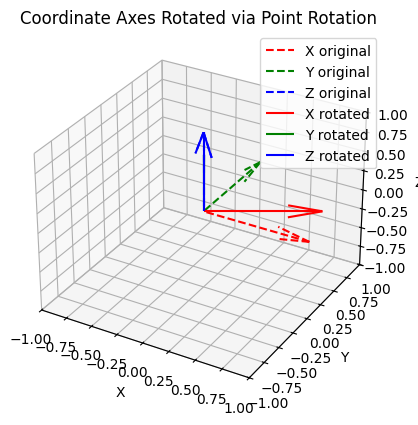

Rotated X axis: [0.8660254 0.5       0.       ]
Rotated Y axis: [-0.5        0.8660254  0.       ]
Rotated Z axis: [0. 0. 1.]


In [9]:
plot_rotated_basis_by_point_rotation(Rz, "Coordinate Axes Rotated via Point Rotation")

In [16]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# 原始角度（ZYX 内旋）
yaw, pitch, roll = 30, 20, 10  # 单位：度

# 构造正向旋转矩阵 A
A = R.from_euler('ZYX', [yaw, pitch, roll], degrees=True).as_matrix()

# 构造逆向旋转矩阵 A_inv（欧拉角取负号）
A_inv_expected = R.from_euler('XYZ', [-roll, -pitch, -yaw], degrees=True).as_matrix()

# 验证是否接近 A.T
print(np.allclose(A.T, A_inv_expected))  # ✅ True

True
